# 2. Exploratory Data Analysis

In [1]:
# import necessary Python modules

import pandas as pd
import string
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
from PIL import Image
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# information of reddit dataset

reddit_df=pd.read_csv("../dataset/webscraping_130323.csv")
print(" Shape of Reddit dataFrame ".center(50, '-'))
print(reddit_df.shape)
print()
print(" Reddit dataFrame Information ".center(50, '-'))
print(reddit_df.info())
print()
print(" Top 5 rows of Reddit dataframe ".center(50, '-'))
reddit_df.head()

----------- Shape of Reddit dataFrame ------------
(2040, 6)

---------- Reddit dataFrame Information ----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   subreddit        2040 non-null   object
 1   title            2040 non-null   object
 2   selftext         1438 non-null   object
 3   author           2040 non-null   object
 4   create_datetime  2040 non-null   object
 5   url              2040 non-null   object
dtypes: object(6)
memory usage: 95.8+ KB
None

--------- Top 5 rows of Reddit dataframe ---------


,subreddit,title,selftext,author,create_datetime,url
0,DotA2,So is this the 2nd Io cosmetic in 6 years that...,Lol. Lmao.,I-Preferred-Digg,08/03/23 12:51:31 AM,https://www.reddit.com/r/DotA2/comments/11l4hi...
1,DotA2,a big thanks to the creator of Lina new set an...,NaN,Bob_108,10/03/23 03:00:19 AM,https://www.reddit.com/r/DotA2/comments/11n0i8...
2,DotA2,what are these creeps in muerta's ability show...,NaN,HellfireBrB,07/03/23 09:01:13 AM,https://www.reddit.com/r/DotA2/comments/11kk9r...
3,DotA2,Buyback mechanic solution for long duration games,NaN,averagemeepo,07/03/23 10:30:50 PM,https://www.reddit.com/r/DotA2/comments/11l0um...
4,DotA2,New meta?,NaN,-click-24-,08/03/23 08:56:02 AM,https://www.reddit.com/r/DotA2/comments/11lhdj...


In [3]:
# to check for duplicates and filter away

reddit_df.duplicated().sum()

0

No duplicate rows were found in both Dota 2 and LoL posts.

In [4]:
# rename column: from selftext to body text

reddit_df.rename(columns={'selftext':'body_text'},inplace=True)

In [5]:
# replace nulls with empty string

reddit_df.body_text.fillna('', inplace=True)

In [6]:
# dummify subreddit column for classification

reddit_df['subreddit_value'] = reddit_df['subreddit'].map({'DotA2': 1, 'leagueoflegends': 0})

In [7]:
# create a new column called post, where it is the merging of title and body text

reddit_df['post'] = reddit_df['title'] + ' ' + reddit_df['body_text']

In [8]:
# verify no more nulls

reddit_df.isnull().sum()

subreddit          0
title              0
body_text          0
author             0
create_datetime    0
url                0
subreddit_value    0
post               0
dtype: int64

In [9]:
reddit_df[reddit_df['body_text']=='[removed]']

,subreddit,title,body_text,author,create_datetime,url,subreddit_value,post


In [10]:
reddit_df[reddit_df['body_text']=='[deleted]']

,subreddit,title,body_text,author,create_datetime,url,subreddit_value,post


No deleted or removed posts were observed in the dataset.

---
The following steps will be performed in text data pre-processing.

- Lowercasing
- Punctuation
- Tokenization
- Stopword removal
- Other text pre-processing methods

---
#### Lowercasing

Text often has a variety of capitalization, mostly used in the beginning of sentences or emphasis on certain nouns. The common approach is to reduce everything to lower case for simplicity. Lowercasing is applicable to most text mining and NLP tasks and significantly helps with consistency of the output.

In [11]:
reddit_df['title'] = reddit_df['title'].map(lambda x: x.lower())
reddit_df['body_text'] = reddit_df['body_text'].map(lambda x: x.lower())
reddit_df['post'] = reddit_df['post'].map(lambda x: x.lower())

In [12]:
reddit_df[['title','body_text','post']]

,title,body_text,post
0,so is this the 2nd io cosmetic in 6 years that...,lol. lmao.,so is this the 2nd io cosmetic in 6 years that...
1,a big thanks to the creator of lina new set an...,,a big thanks to the creator of lina new set an...
2,what are these creeps in muerta's ability show...,,what are these creeps in muerta's ability show...
3,buyback mechanic solution for long duration games,,buyback mechanic solution for long duration ga...
4,new meta?,,new meta?
...,...,...,...
2035,anyone's legend vs. edward gaming / lpl 2023 s...,###lpl 2023 spring \n[official...,anyone's legend vs. edward gaming / lpl 2023 s...
2036,how to fix yuumi,when yuumi attackes to a champ she stores the...,how to fix yuumi when yuumi attackes to a cha...
2037,pyosik speaks about whether or not stage nerve...,,pyosik speaks about whether or not stage nerve...
2038,"fly eyla on flyquest's weaknesses: ""from what ...",,"fly eyla on flyquest's weaknesses: ""from what ..."


---
#### Punctuation

Punctuation removal is intended to help treat each text equally. For example, the words "data" and "data!" are treated equally after removing punctuation. We import the string module in Python and verify our text against the pre-initialised string of punctuations.

In [13]:
# pre-initialized string used as a constant to verify against the text

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [14]:
# define function to remove punctuation in both post title and body text

def remove_punctuation(text):
    output=''
    for i in text:
        if i in string.punctuation:
            output+=' '
        else:
            output+=i
    return output

reddit_df['title_no_punct'] = reddit_df['title'].map(lambda x: remove_punctuation(x))
reddit_df['body_text_no_punct'] = reddit_df['body_text'].map(lambda x: remove_punctuation(x))
reddit_df['post_no_punct'] = reddit_df['post'].map(lambda x: remove_punctuation(x))

In [15]:
reddit_df[['title_no_punct','body_text_no_punct','post_no_punct']]

,title_no_punct,body_text_no_punct,post_no_punct
0,so is this the 2nd io cosmetic in 6 years that...,lol lmao,so is this the 2nd io cosmetic in 6 years that...
1,a big thanks to the creator of lina new set an...,,a big thanks to the creator of lina new set an...
2,what are these creeps in muerta s ability show...,,what are these creeps in muerta s ability show...
3,buyback mechanic solution for long duration games,,buyback mechanic solution for long duration ga...
4,new meta,,new meta
...,...,...,...
2035,anyone s legend vs edward gaming lpl 2023 s...,lpl 2023 spring \n official...,anyone s legend vs edward gaming lpl 2023 s...
2036,how to fix yuumi,when yuumi attackes to a champ she stores the...,how to fix yuumi when yuumi attackes to a cha...
2037,pyosik speaks about whether or not stage nerve...,,pyosik speaks about whether or not stage nerve...
2038,fly eyla on flyquest s weaknesses from what ...,,fly eyla on flyquest s weaknesses from what ...


---
#### Tokenization

Tokenization refers to the separation of an entire text document into smaller units called tokens. They can exist in the form of words, characters or sequences of words (N-grams). Token formation is commonly done using spacing as a delimiter to break down the text. It is required as the meaning of the text can easily be interpreted by analyzing the words present in the text.

In [16]:
# define tokenizer to split string using regular expression, if there is a match the result will consist of alphabetical characters (lowercase) only

tokenizer = RegexpTokenizer(r'[a-z]+')

In [17]:
# tokenise all the posts after lowercasing the strings

reddit_df['tokenised_post_no_punct']=reddit_df['post_no_punct'].map(lambda x: tokenizer.tokenize(x))

In [18]:
reddit_df['tokenised_post_no_punct']

0       [so, is, this, the, nd, io, cosmetic, in, year...
1       [a, big, thanks, to, the, creator, of, lina, n...
2       [what, are, these, creeps, in, muerta, s, abil...
3       [buyback, mechanic, solution, for, long, durat...
4                                             [new, meta]
                              ...                        
2035    [anyone, s, legend, vs, edward, gaming, lpl, s...
2036    [how, to, fix, yuumi, when, yuumi, attackes, t...
2037    [pyosik, speaks, about, whether, or, not, stag...
2038    [fly, eyla, on, flyquest, s, weaknesses, from,...
2039    [why, wits, end, is, named, wits, end, at, the...
Name: tokenised_post_no_punct, Length: 2040, dtype: object

---
#### Stopword Removal

Stopwords are words which are generally filtered out before processing a piece of text. They are commonly used words and usually do not add significant insights to the text, hence available in abundance in any human language. By removing them, we remove the low-level information from our text in order to give more focus to the important information. In other words, we can say that the removal of such words are unlikely to have significant influence on the model that we train for our tasks. Furthermore, removal of stopwords also helps to reduce the dataset size and therefore the training time as fewer tokens are involved.

In this section, an example of stopword removal on the post column is shown in the function below. The stopword removal on the title and text body columns will be done separately in another section later.

In [19]:
# define stopwords

stop=set(stopwords.words('english'))

In [20]:
#list of stopwords from NLTK

print(stop)

{'him', 'up', 'those', 'after', "wasn't", 'once', 'can', 'wasn', 'won', 'both', 'where', 'during', 'against', "shouldn't", 'aren', 'm', 'he', 'doing', 'out', 'here', 'who', 'about', "didn't", "hasn't", 'some', 'itself', 'these', 'are', 'a', 'ain', 'its', 'off', 'our', 'at', 'should', 'only', 'needn', 'myself', 'did', 'this', 'other', "hadn't", "wouldn't", 'or', 'each', 'such', 'it', 'their', 'from', 'having', "needn't", 'theirs', 'himself', "won't", "aren't", 'her', 'have', "it's", 'in', 'don', 've', 'into', 'that', 'i', 'is', 'had', "you'd", 'ourselves', 'shan', 'with', "weren't", 'under', 'again', 'will', 'more', 'between', 'am', 'through', 'shouldn', 'you', 'ours', 'yourself', 'mustn', 'couldn', 'was', 'how', 't', 'my', 'any', 'what', 'but', 'were', 'on', 'whom', "she's", 'when', 'there', 'y', 'by', 'nor', 'they', "that'll", 'them', 'do', 'and', "shan't", 'mightn', 'now', 'very', "don't", 'why', 'while', 'has', 'no', 'does', 'she', 'isn', 'which', 'didn', 'for', 'further', "mightn't

In [21]:
# define a function to remove stopwords from the tokenized post column

def remove_stopwords(text):
    text=[word.lower() for word in text if word not in stop]
    return text

reddit_df['tokenised_post_no_punct_no_stopwords'] = reddit_df['tokenised_post_no_punct'].apply(lambda x: remove_stopwords(x))

In [22]:
reddit_df['tokenised_post_no_punct_no_stopwords']

0       [nd, io, cosmetic, years, untradable, unmarket...
1       [big, thanks, creator, lina, new, set, good, m...
2                     [creeps, muerta, ability, showcase]
3       [buyback, mechanic, solution, long, duration, ...
4                                             [new, meta]
                              ...                        
2035    [anyone, legend, vs, edward, gaming, lpl, spri...
2036    [fix, yuumi, yuumi, attackes, champ, stores, q...
2037    [pyosik, speaks, whether, stage, nerves, affec...
2038    [fly, eyla, flyquest, weaknesses, experienced,...
2039    [wits, end, named, wits, end, begining, story,...
Name: tokenised_post_no_punct_no_stopwords, Length: 2040, dtype: object

---
#### Other text pre-processing methods

In this section, further data cleaning on the text was performed. Another custom function was defined to remove other strings such as weblinks (i.e. contain http) and also those that have "\n" (denote newline) in them. Numeric and non-alphanumeric strings were identified and added to the stopword list. 

In [23]:
# define stopword removal function to remove stopwords from post title and body text
# function to import text and remove newline and web URL strings (eg. "http")

def text_cleaning(text):
    result=[]
    if type(text)==list:
        text=' '.join(text)
    text=text.replace("\n"," ")
    for x in text.split(" "):
        if not x.isalnum():
            pass
        elif 'http' in x:
            result.append(x[:x.index('http')])
        else:
            result.append(x.lower())
    result=list(set(result))
    return ' '.join(result)

In [24]:
reddit_df['cleaned_title_no_punct'] = reddit_df['title_no_punct'].map(lambda x: text_cleaning(x))
reddit_df['cleaned_body_text_no_punct'] = reddit_df['body_text_no_punct'].map(lambda x: text_cleaning(x))
reddit_df['cleaned_tokenised_post_no_punct_no_stopwords']=reddit_df['tokenised_post_no_punct_no_stopwords'].map(lambda x: text_cleaning(x))

---
#### Exploring top words in Dota 2 and LoL posts

In [25]:
# define stopword removal function to remove stopwords from post title and body text
# function to input corpus and extra stopwords if required (if no extra stopwords, to input None)

def get_top_words(corpus,extra_stopwords):
    stop = set(stopwords.words('english'))
    if extra_stopwords==None:
        pass
    else:
        stop.update(set(extra_stopwords))
    cvec = CountVectorizer(stop_words=stop).fit(corpus)
    bag_of_words = cvec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in cvec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [26]:
lol_title_topwords=get_top_words(corpus=reddit_df[reddit_df['subreddit_value']==0]['cleaned_title_no_punct'],extra_stopwords=None)
dota2_title_topwords=get_top_words(corpus=reddit_df[reddit_df['subreddit_value']==1]['cleaned_title_no_punct'],extra_stopwords=None)

In [27]:
lol_body_text_topwords=get_top_words(corpus=reddit_df[reddit_df['subreddit_value']==0]['cleaned_body_text_no_punct'],extra_stopwords=None)
dota2_body_text_topwords=get_top_words(corpus=reddit_df[reddit_df['subreddit_value']==1]['cleaned_body_text_no_punct'],extra_stopwords=None)

In [28]:
# to filter away all non-alphabetical and numeric text

dota2_numeric = [x[0] for x in dota2_title_topwords if x[0].isnumeric()] + [x[0] for x in dota2_body_text_topwords if x[0].isnumeric()]
lol_numeric = [x[0] for x in lol_title_topwords if x[0].isnumeric()] + [x[0] for x in lol_body_text_topwords if x[0].isnumeric()]
dota2_non_alpha = [x[0] for x in dota2_title_topwords if not x[0].isalpha()] + [x[0] for x in dota2_body_text_topwords if not x[0].isalpha()]
lol_non_alpha = [x[0] for x in lol_title_topwords if not x[0].isalpha()] + [x[0] for x in lol_body_text_topwords if not x[0].isalpha()]

In [29]:
# add in extra stopwords for better data quality
extra_stopwords=dota2_numeric+lol_numeric+dota2_non_alpha+lol_non_alpha+['im','dont','would','cant','amp','www','com','webp']
lol_title_topwords=get_top_words(corpus=reddit_df[reddit_df['subreddit_value']==0]['cleaned_title_no_punct'],extra_stopwords=extra_stopwords)
dota2_title_topwords=get_top_words(corpus=reddit_df[reddit_df['subreddit_value']==1]['cleaned_title_no_punct'],extra_stopwords=extra_stopwords)
lol_body_text_topwords=get_top_words(corpus=reddit_df[reddit_df['subreddit_value']==0]['cleaned_body_text_no_punct'],extra_stopwords=extra_stopwords)
dota2_body_text_topwords=get_top_words(corpus=reddit_df[reddit_df['subreddit_value']==1]['cleaned_body_text_no_punct'],extra_stopwords=extra_stopwords)

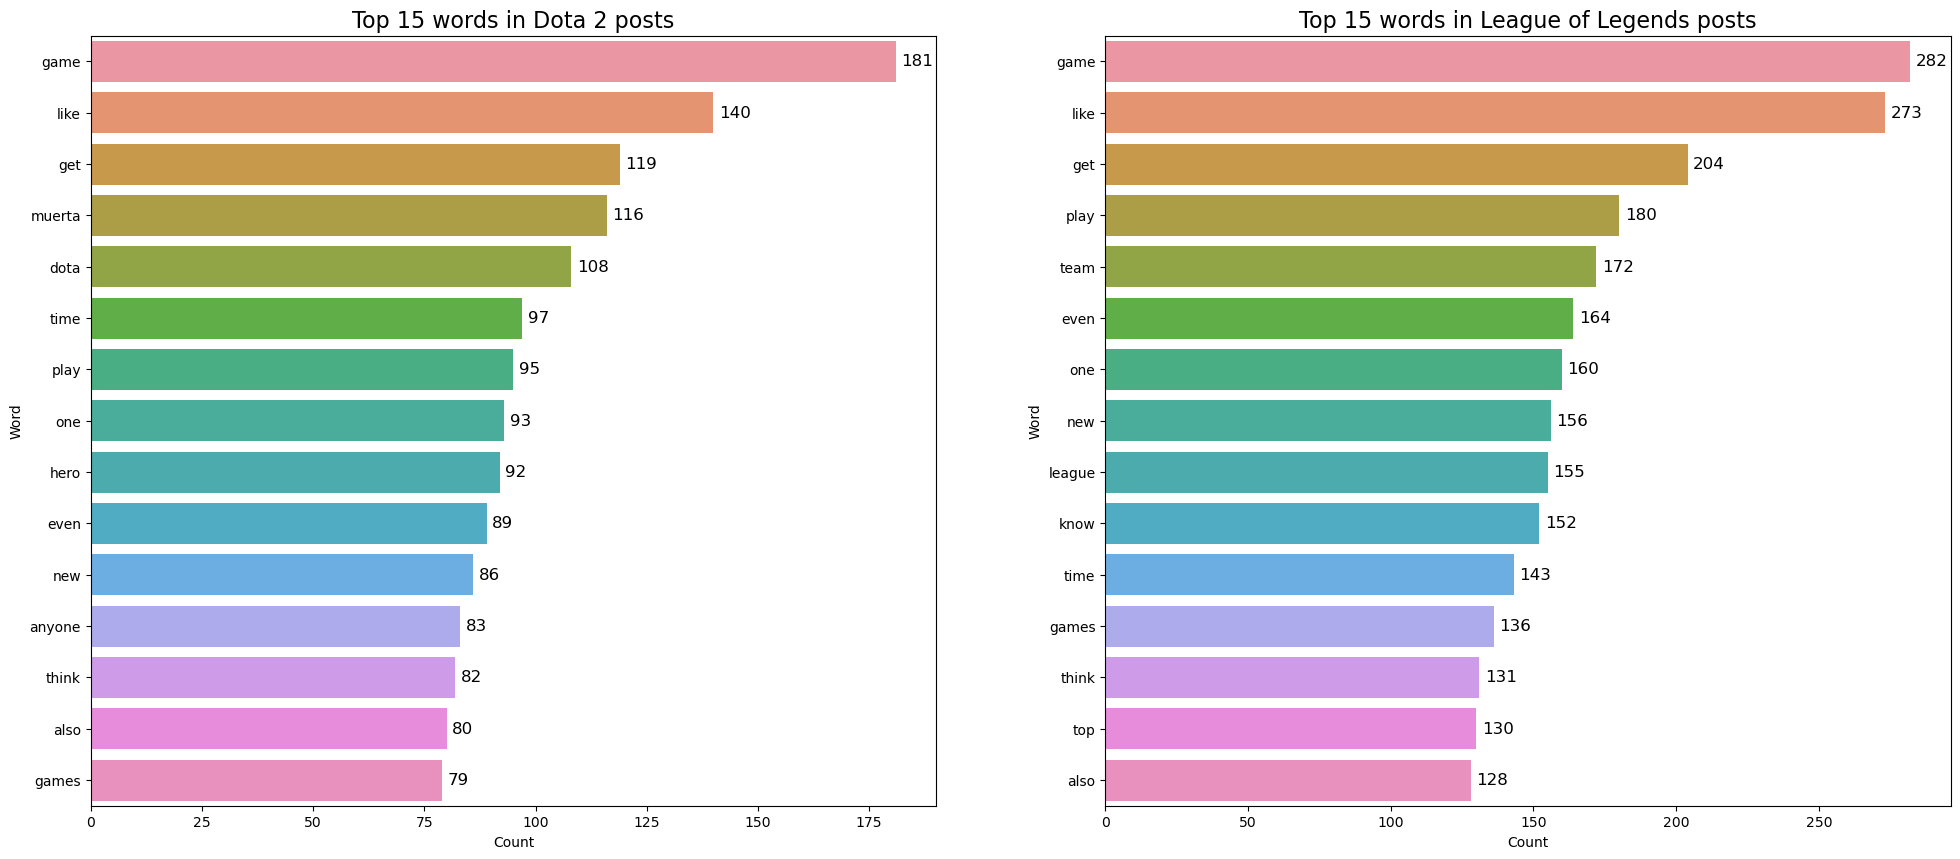

In [30]:
# plot top words in dota 2 and LoL posts

result1=pd.DataFrame(dota2_title_topwords+dota2_body_text_topwords).rename(columns={0:'Word',1:'Count'}).reset_index(drop=True).sort_values(
    by='Count',ascending=False).iloc[:20,:]
result2=pd.DataFrame(lol_title_topwords+lol_body_text_topwords).rename(columns={0:'Word',1:'Count'}).reset_index(drop=True).sort_values(
    by='Count',ascending=False).iloc[:20,:]

fig,axes=plt.subplots(1,2,figsize=(24,10))
sns.barplot(data=result1.iloc[0:15,:],x="Count",y="Word",ax=axes[0]).set_title(f"Top 15 words in Dota 2 posts",fontsize=16)
axes[0].bar_label(axes[0].containers[0],label_type='edge',padding=4,fontsize=12)
sns.barplot(data=result2.iloc[0:15,:],x="Count",y="Word",ax=axes[1]).set_title(f"Top 15 words in League of Legends posts",fontsize=16)
axes[1].bar_label(axes[1].containers[0],label_type='edge',padding=4,fontsize=12)
plt.show()

---
#### Venn Diagram Visualisation

We observe that LoL posts have significantly more unique words than Dota 2 posts, which is estimated to be around 46% of the total words.

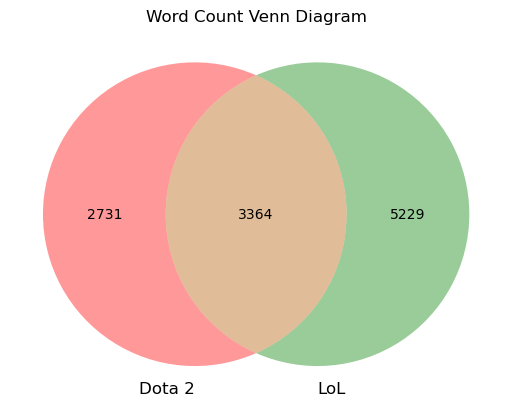

In [31]:
A=set([x[0] for x in dota2_title_topwords+dota2_body_text_topwords])
B=set([x[0] for x in lol_title_topwords+lol_body_text_topwords])
v=venn2_unweighted([A, B],set_labels = ('Dota 2','LoL'), set_colors=('r', 'g'), alpha = 0.4)
plt.title('Word Count Venn Diagram')
plt.show()

---
#### Wordcloud Visualisation


A wordcloud is a graphical representation of word frequency that gives greater prominence to words that appear more frequently in a source text, where words come in different colours and sizes. The bigger and bolder a word appears, the more often it is mentioned within a given text and it is deemed to be more important. In below example, 2 wordclouds were generated from the post column after data cleaning has been done. One of them resembles the Dota 2 Logo, whereas the other one resembles the LoL logo.

In [32]:
# import wordcloud template

dota2_mask = np.array(Image.open("../images/dota2.png"))
lol_mask= np.array(Image.open("../images/lol.png"))

In [33]:
# Make the template background white, so that the wordcloud will not be masked by original image

def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

transformed_dota2_mask = np.ndarray((dota2_mask.shape[0],dota2_mask.shape[1],dota2_mask.shape[2]), np.int32)
transformed_lol_mask = np.ndarray((lol_mask.shape[0],lol_mask.shape[1],lol_mask.shape[2]), np.int32)

for i in range(len(dota2_mask)):
    for j in range(len(dota2_mask[i])):
        transformed_dota2_mask[i][j] = list(map(transform_format, dota2_mask[i][j]))
        
for i in range(len(lol_mask)):
    for j in range(len(lol_mask[i])):
        transformed_lol_mask[i][j] = list(map(transform_format, lol_mask[i][j]))

Dota 2 Wordcloud



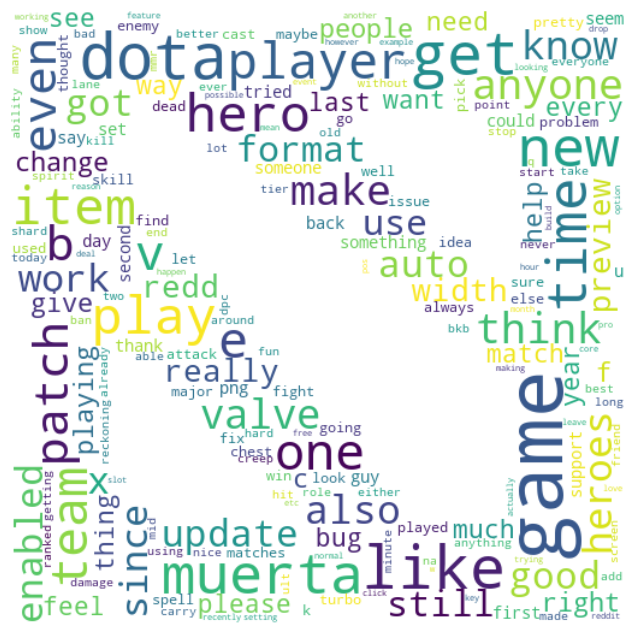



League of Legends Wordcloud



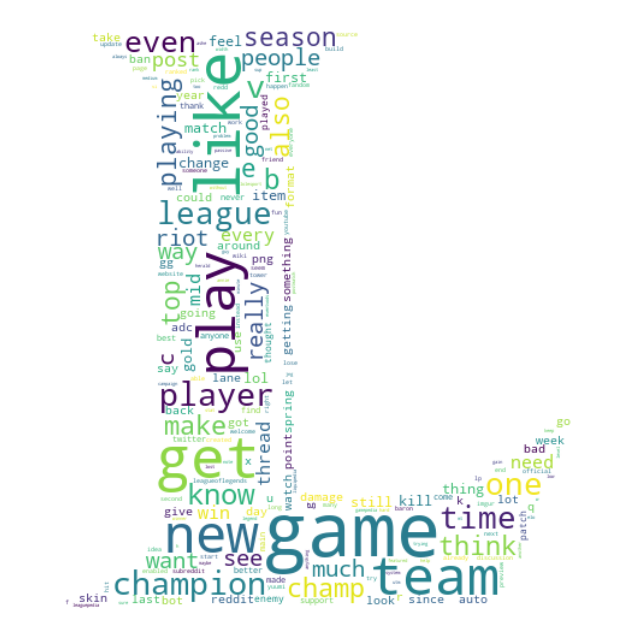

In [34]:
def plot_wordcloud(corpus,extra_stopwords,mask):
    stop = set(stopwords.words('english'))
    if extra_stopwords==None:
        pass
    else:
        stop.update(set(extra_stopwords))
    wordcloud = WordCloud(stopwords=stop, background_color="white", mask=mask,contour_width=0,collocations=False).generate(corpus)
    plt.subplots(1,1,figsize=(16,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

print('Dota 2 Wordcloud\n')
plot_wordcloud(' '.join([x for x in reddit_df[reddit_df['subreddit']=='DotA2']['cleaned_tokenised_post_no_punct_no_stopwords']]),
               extra_stopwords=extra_stopwords,mask=transformed_dota2_mask)
print('\n')
print('League of Legends Wordcloud\n')
plot_wordcloud(' '.join([x for x in reddit_df[reddit_df['subreddit']=='leagueoflegends']['cleaned_tokenised_post_no_punct_no_stopwords']]),
               extra_stopwords=extra_stopwords,mask=transformed_lol_mask)

---
#### Exploring Word Count

In [35]:
reddit_df['cleaned_body_text_no_punct'].map(lambda x: x.split())

0                                             [lol, lmao]
1                                                      []
2                                                      []
3                                                      []
4                                                      []
                              ...                        
2035    [11, welcome, meiko, annie, leaguepedia, es, 1...
2036    [him, can, wombo, won, least, current, 5, out,...
2037                                                   []
2038                                                   []
2039    [it, was, not, story, from, begining, resist, ...
Name: cleaned_body_text_no_punct, Length: 2040, dtype: object

In [36]:
#reddit_df['post_word_count'] = reddit_df['tokenised_post_no_punct_no_stopwords'].map(lambda x: len(x))
reddit_df['post_word_count'] = reddit_df['cleaned_body_text_no_punct'].map(lambda x: len(x.split()))

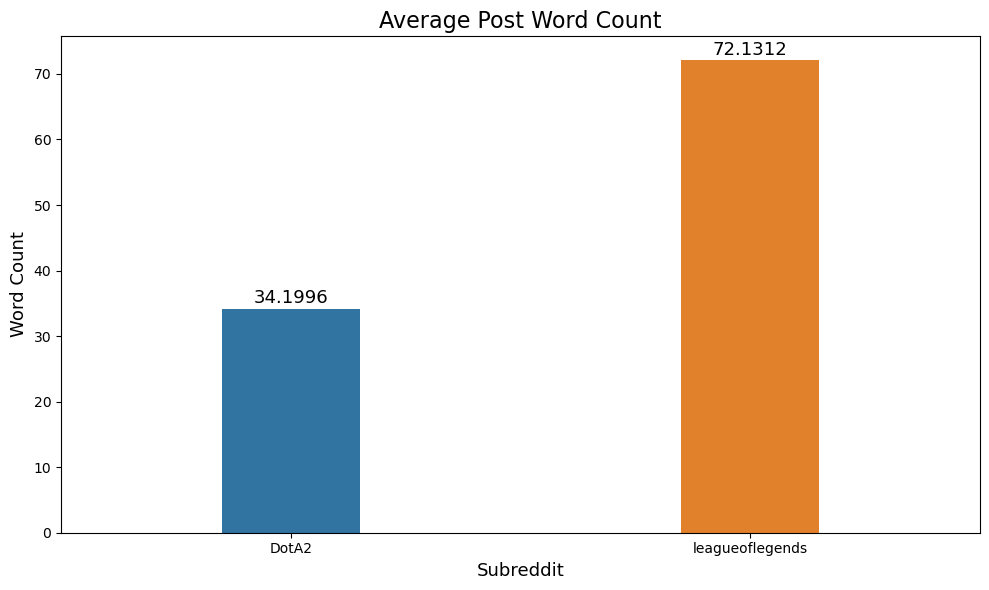

In [37]:
fig,axes=plt.subplots(1,1,figsize=(10,6))
sns.barplot(x=reddit_df["subreddit"],y=reddit_df['post_word_count'],errorbar=None,width=0.3).set_title(f"Average Post Word Count",fontsize=16)
axes.set_xlabel('Subreddit', fontsize = 13)
axes.set_ylabel('Word Count', fontsize = 13)
axes.bar_label(axes.containers[0],label_type='edge',padding=1,fontsize=13)
plt.tight_layout()
plt.show()

On average, LoL posts generally have 2 times as many words as Dota 2 posts.

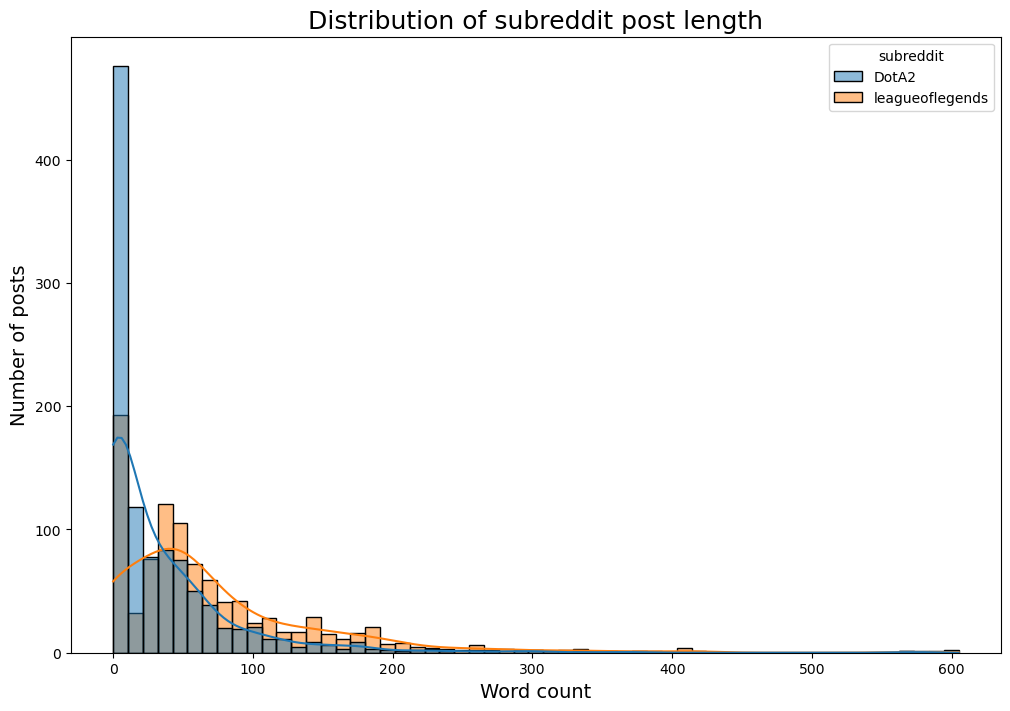

In [38]:
fig,axes=plt.subplots(1,1,figsize=(12,8))
sns.histplot(data=reddit_df, x='post_word_count', hue='subreddit', kde=True)
axes.set_xlabel('Word count', fontsize = 14);
axes.set_ylabel('Number of posts', fontsize = 14)
plt.title("Distribution of subreddit post length",fontsize=18)
plt.show()

In [39]:
reddit_df.groupby('subreddit')[['post_word_count']].describe()

post_word_count                                               \
                          count       mean        std  min   25%   50%   75%   
subreddit                                                                      
DotA2                    1057.0  34.199622  54.940523  0.0   0.0  16.0  48.0   
leagueoflegends           983.0  72.131231  79.062725  0.0  25.0  50.0  93.5   

                        
                   max  
subreddit               
DotA2            584.0  
leagueoflegends  605.0

Comparing by word count distribution, Dota 2 is more right-skewed as compared to LoL. Minimal outliers observed, which is probably due to posts that contain information about tournaments/seasonal competitions. Therefore the word count is abnormally high.

In [40]:
# save post EDA data to new csv

reddit_df.to_csv("../dataset/post_EDA_130323.csv",index=False)

In [41]:
# save customized stopword list as json and import later to other notebooks

all_stopwords=list(stop)+extra_stopwords
with open("../dataset/stopwords.json", "w") as file:
    json.dump(all_stopwords,file)